In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/capstone_project_data" "/content/capstone_project_data"


Mounted at /gdrive


In [2]:
# Install required libraries
!pip install matplotlib seaborn scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
files = {
    "AgeGroup": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-AgeGroup.xlsx",
    "Citz": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-Citz.xlsx",
    "CitzImmCat": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-CitzImmCat.xlsx",
    "CMA": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-CMA.xlsx",
    "ProvImmCat": "/gdrive/My Drive/capstone_project_data/EN_ODP-PR-ProvImmCat.xlsx",
}

In [4]:
# Load all datasets
datasets = {name: pd.ExcelFile(path) for name, path in files.items()}

In [5]:
# Extract sheet names for each file
sheet_names = {name: dataset.sheet_names for name, dataset in datasets.items()}

In [6]:
# Load the sheets into DataFrames
dfs = {
    "AgeGroup": datasets["AgeGroup"].parse("PR - Age"),
    "CMA": datasets["CMA"].parse("PR - CMA"),
    "CitzImmCat": datasets["CitzImmCat"].parse("PR - ImmCat"),
    "Citz": datasets["Citz"].parse("PR - CITZ"),
}

In [7]:
# Clean datasets
def clean_dataframe(df):
    df = df.dropna(how='all')  # Drop completely empty rows
    df.columns = df.iloc[1]  # Use second row as header
    df = df[2:].reset_index(drop=True)  # Drop previous header rows
    df = df.dropna(axis=1, how='all')  # Drop empty columns
    return df

In [8]:
# Apply cleaning function
cleaned_dfs = {name: clean_dataframe(df) for name, df in dfs.items()}

In [9]:

# Function to extract relevant data dynamically
def clean_extract(df, header_idx, key_col_name, total_col_name):
    """Extracts and cleans relevant data dynamically."""
    df = df.dropna(how="all").reset_index(drop=True)  # Remove empty rows
    df.columns = df.iloc[header_idx]  # Set correct headers
    df = df[(header_idx + 1):].reset_index(drop=True)  # Remove previous headers

    # Ensure key column and total admissions column exist
    if key_col_name in df.columns and total_col_name in df.columns:
        df = df[[key_col_name, total_col_name]].dropna()
        df.columns = ["Category", "Total Admissions"]

        # Clean numeric values
        #df["Total Admissions"] = df["Total Admissions"].astype(str).str.replace(",", "").replace("--", "0").astype(int)
        df["Total Admissions"] = df["Total Admissions"].fillna("0").astype(str).str.replace(",", "").replace("--", "0").astype(int)
        return df

    return None

In [10]:
# Manually setting correct column names
column_names_manual = {
    "AgeGroup": ("0 to 14 years old", "1,465"),
    "CMA": ("St. John's", "3,985"),
    "CitzImmCat": ("Worker Program", "85"),
    "Citz": ("Afghanistan", "12,280"),
}

header_indices = {
    "AgeGroup": 1,
    "CMA": 1,
    "CitzImmCat": 6,
    "Citz": 1,
}

In [11]:
# Apply extraction method to datasets
age_group_df = clean_extract(cleaned_dfs["AgeGroup"], header_indices["AgeGroup"], *column_names_manual["AgeGroup"])
cma_df = clean_extract(cleaned_dfs["CMA"], header_indices["CMA"], *column_names_manual["CMA"])
imm_cat_df = clean_extract(cleaned_dfs["CitzImmCat"], header_indices["CitzImmCat"], *column_names_manual["CitzImmCat"])
citizenship_df = clean_extract(cleaned_dfs["Citz"], header_indices["Citz"], *column_names_manual["Citz"])


In [12]:
import json

def format_df_for_json(df):
    """Formats a DataFrame for JSON output with indentation."""
    if df is not None:
        return df.to_dict(orient='records')  # Convert to list of dicts
    else:
        return "Extraction Failed"


extracted_results = {
    "Age Group": format_df_for_json(age_group_df.head()),
    "CMA": format_df_for_json(cma_df.head()),
    "Immigration Category": format_df_for_json(imm_cat_df.head()),
    "Citizenship": format_df_for_json(citizenship_df.head()),
}

# Convert to JSON string with indentation
extracted_results_json = json.dumps(extracted_results, indent=4)

# Print the indented JSON
print(extracted_results_json)

{
    "Age Group": [
        {
            "Category": "15 to 29 years old",
            "Total Admissions": 1530
        },
        {
            "Category": "30 to 44 years old",
            "Total Admissions": 2260
        },
        {
            "Category": "45 to 59 years old",
            "Total Admissions": 420
        },
        {
            "Category": "60 to 74 years old",
            "Total Admissions": 70
        },
        {
            "Category": "75 years old or more",
            "Total Admissions": 5
        }
    ],
    "CMA": [
        {
            "Category": "Corner Brook",
            "Total Admissions": 275
        },
        {
            "Category": "Gander",
            "Total Admissions": 230
        },
        {
            "Category": "Grand Falls-Windsor",
            "Total Admissions": 75
        },
        {
            "Category": "Other - Newfoundland and Labrador",
            "Total Admissions": 1190
        },
        {
            "Category": 

In [13]:
file_path = files["ProvImmCat"]
excel_file = pd.ExcelFile(file_path)

In [14]:
# Extract and clean Provincial Immigration Categories
def extract_provincial_immigration(df):
    header_index = 3  # Adjusted based on observation
    df.columns = df.iloc[header_index]
    df = df[(header_index + 1):].reset_index(drop=True)
    df = df.dropna(axis=1, how='all')
    df = df.iloc[:, [3, -1]]  # Selecting Province and Total Admissions
    df.columns = ["Province", "Total Admissions"]
    df["Total Admissions"] = df["Total Admissions"].fillna("0").astype(str).str.replace(",", "").replace("--", "0").astype(int)
    df = df.dropna(subset=["Province"])
    return df

In [15]:
# Load the sheet and apply extraction
df_prov_imm_cat = excel_file.parse("PR - ImmCat")
prov_imm_cat_df = extract_provincial_immigration(df_prov_imm_cat)

In [16]:
# Store the cleaned dataset
cleaned_dfs["ProvImmCat"] = prov_imm_cat_df

In [17]:
# Display the cleaned dataset in Jupyter
from IPython.display import display
display(prov_imm_cat_df)

,Province,Total Admissions
0,Agri-Food Pilot,0
1,Atlantic Immigration Pilot Programs,15
2,Atlantic Immigration Programs,1075
3,Canadian Experience,60
4,Caregiver,10
...,...,...
361,Sponsored Children,5
362,Sponsored Extended Family Member,0
363,Sponsored Parent or Grandparent,10
364,Sponsored Spouse or Partner,35


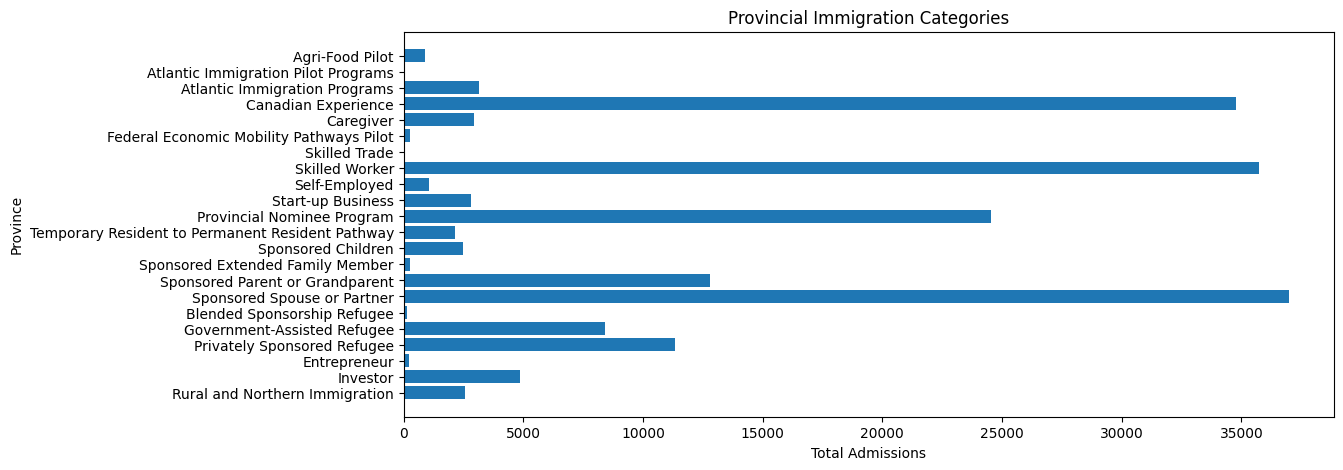

In [18]:
# Visualization: Provincial Immigration Categories
plt.figure(figsize=(12, 5))
plt.barh(prov_imm_cat_df["Province"], prov_imm_cat_df["Total Admissions"])
plt.xlabel("Total Admissions")
plt.ylabel("Province")
plt.title("Provincial Immigration Categories")
plt.gca().invert_yaxis()
plt.show()

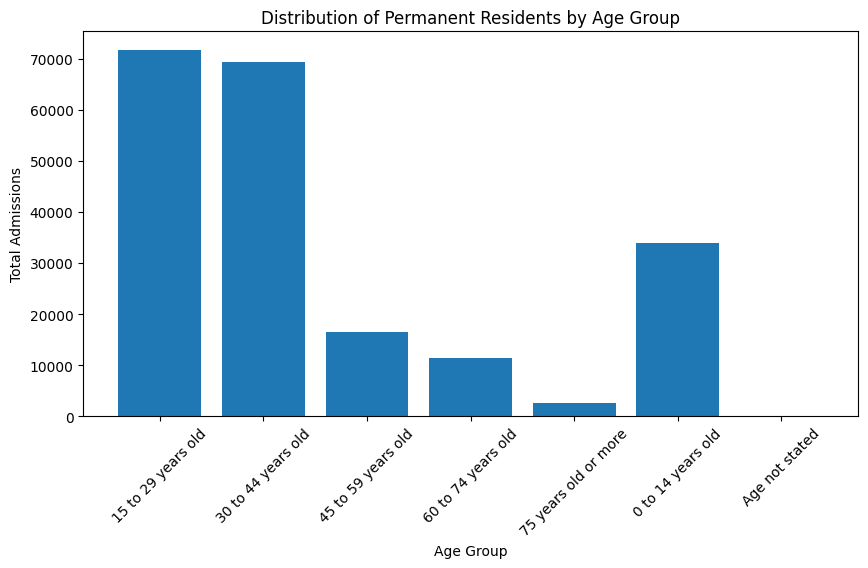

In [19]:


# Age Group Distribution
plt.figure(figsize=(10, 5))
plt.bar(age_group_df["Category"], age_group_df["Total Admissions"])
plt.xlabel("Age Group")
plt.ylabel("Total Admissions")
plt.title("Distribution of Permanent Residents by Age Group")
plt.xticks(rotation=45)
plt.show()


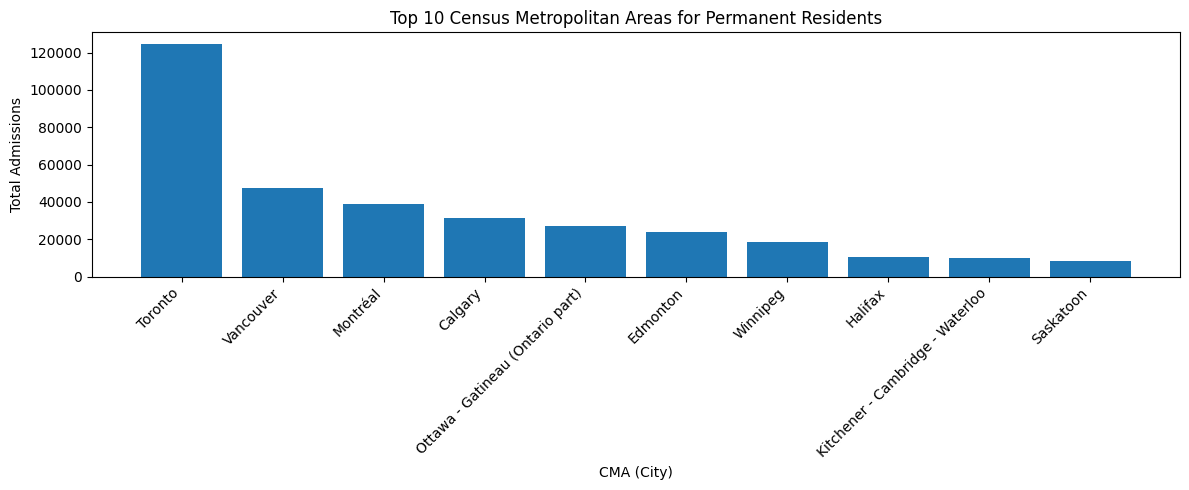

In [20]:

# Preferred CMAs

# Sort by Total Admissions and get top 10
top_10_cma_df = cma_df.sort_values(by="Total Admissions", ascending=False).head(10)

# Now plot using this filtered DataFrame
plt.figure(figsize=(12, 5))  # Adjust figure size for better readability
plt.bar(top_10_cma_df["Category"], top_10_cma_df["Total Admissions"])
plt.xlabel("CMA (City)")
plt.ylabel("Total Admissions")
plt.title("Top 10 Census Metropolitan Areas for Permanent Residents")
plt.xticks(rotation=45, ha='right')  # Rotate and align labels for better visibility
plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()

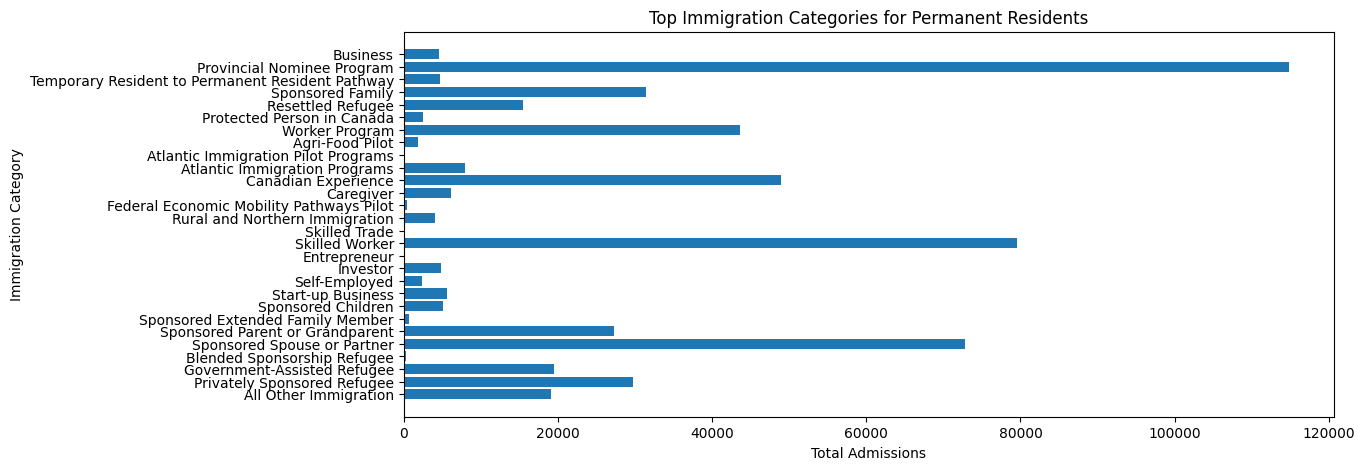

In [21]:
# Immigration Categories
plt.figure(figsize=(12, 5))
plt.barh(imm_cat_df["Category"], imm_cat_df["Total Admissions"])
plt.xlabel("Total Admissions")
plt.ylabel("Immigration Category")
plt.title("Top Immigration Categories for Permanent Residents")
plt.gca().invert_yaxis()
plt.show()

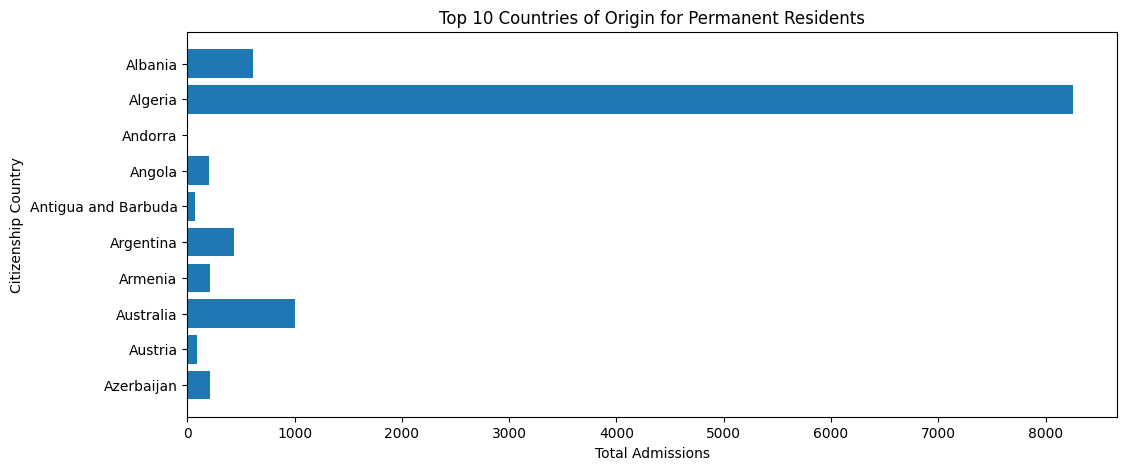

In [22]:
#Citizenship Trends
plt.figure(figsize=(12, 5))
plt.barh(citizenship_df["Category"].head(10), citizenship_df["Total Admissions"].head(10))
plt.xlabel("Total Admissions")
plt.ylabel("Citizenship Country")
plt.title("Top 10 Countries of Origin for Permanent Residents")
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Load the Excel file
file_path = files["CMA"]
xls = pd.ExcelFile(file_path)

In [24]:
# Load the sheet without specifying columns to preserve structure
sheet_name = "PR - CMA"
df_full = pd.read_excel(xls, sheet_name=sheet_name, skiprows=3)

In [25]:
# Identifying the correct column for province names
province_column = df_full.columns[0]  # First column contains province names

In [26]:
# Identifying the columns that contain yearly total values (last occurrence of each year)
yearly_total_columns = {}
for year in range(2015, 2025):
    matching_cols = [col for col in df_full.columns if str(year) in str(col)]
    if matching_cols:
        yearly_total_columns[year] = matching_cols[-1]  # Last occurrence is likely the total

# Extracting only the relevant columns
df_extracted = df_full[[province_column] + list(yearly_total_columns.values())].copy()

# Renaming columns
df_extracted.rename(columns={province_column: "Province/Territory", **{v: k for k, v in yearly_total_columns.items()}}, inplace=True)

# Cleaning province names
df_extracted["Province/Territory"] = df_extracted["Province/Territory"].astype(str).str.strip()

# Convert numerical columns to proper format by removing commas
for col in range(2015, 2025):
    df_extracted[col] = df_extracted[col].astype(str).str.replace(',', '', regex=True)
    df_extracted[col] = pd.to_numeric(df_extracted[col], errors='coerce')

In [27]:
# Defining the required provinces/territories
required_provinces = [
    "Newfoundland and Labrador Total", "Prince Edward Island Total", "Nova Scotia Total",
    "New Brunswick Total", "Quebec Total", "Ontario Total", "Manitoba Total",
    "Saskatchewan Total", "Alberta Total", "British Columbia Total", "Yukon Total",
    "Northwest Territories Total", "Nunavut Total"
]

# Filtering for the required provinces/territories after cleaning names
df_final_cleaned = df_extracted[df_extracted["Province/Territory"].isin(required_provinces)]

# Save the final extracted data to a CSV file for review
df_final_cleaned.to_csv("final_extracted_yearly_totals.csv", index=False)

# Print first few rows to verify output
print(df_final_cleaned.head())

                 Province/Territory     2015     2016     2017     2018  \
6   Newfoundland and Labrador Total   1120.0   1200.0   1185.0   1525.0   
10       Prince Edward Island Total   1190.0   2315.0   2345.0   2125.0   
17                Nova Scotia Total   3425.0   5510.0   4515.0   5985.0   
26              New Brunswick Total   2580.0   4715.0   3660.0   4610.0   
59                     Quebec Total  49015.0  53235.0  52380.0  51125.0   

       2019     2020     2021     2022     2023     2024  
6    1855.0    900.0   2045.0   3495.0   5485.0   5755.0  
10   2445.0   1290.0   2615.0   2670.0   3620.0   3980.0  
17   7595.0   3520.0   9170.0  12655.0  11805.0  14285.0  
26   6005.0   2890.0   5315.0  10230.0  11460.0  15490.0  
59  40565.0  25240.0  50275.0  68715.0  52810.0  59425.0  


In [28]:
# Load the sheet
sheet_name = "PR - CMA"
df_full = pd.read_excel(xls, sheet_name=sheet_name, skiprows=3)

In [29]:
# Identify province column
province_column = df_full.columns[0]

In [30]:
# Identify yearly total columns
yearly_total_columns = {}
for year in range(2015, 2025):
    matching_cols = [col for col in df_full.columns if str(year) in str(col)]
    if matching_cols:
        yearly_total_columns[year] = matching_cols[-1]

# Extract relevant columns
df_extracted = df_full[[province_column] + list(yearly_total_columns.values())].copy()

# Rename columns
df_extracted.rename(columns={province_column: "Province/Territory", **{v: k for k, v in yearly_total_columns.items()}}, inplace=True)

# Clean province names
df_extracted["Province/Territory"] = df_extracted["Province/Territory"].astype(str).str.strip()

# Convert numerical columns
for col in range(2015, 2025):
    df_extracted[col] = df_extracted[col].astype(str).str.replace(',', '', regex=True)
    df_extracted[col] = pd.to_numeric(df_extracted[col], errors='coerce')


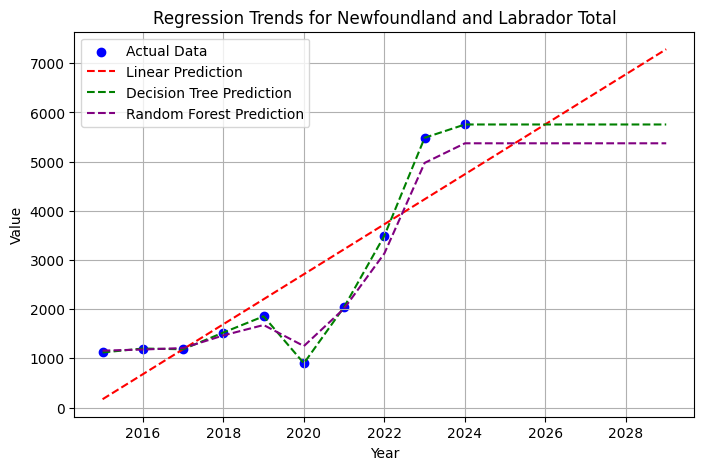

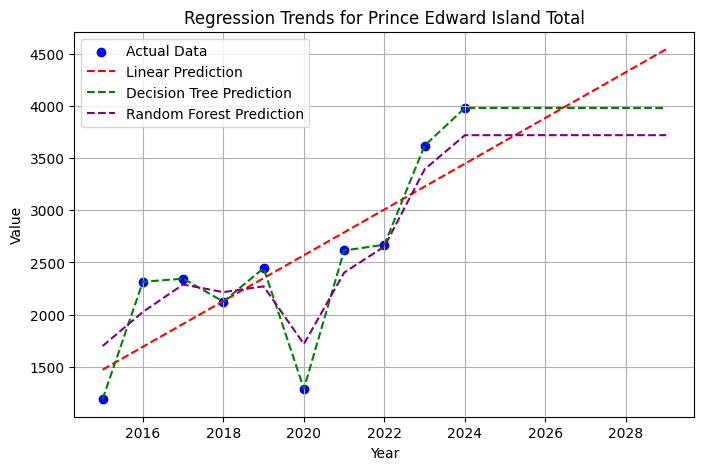

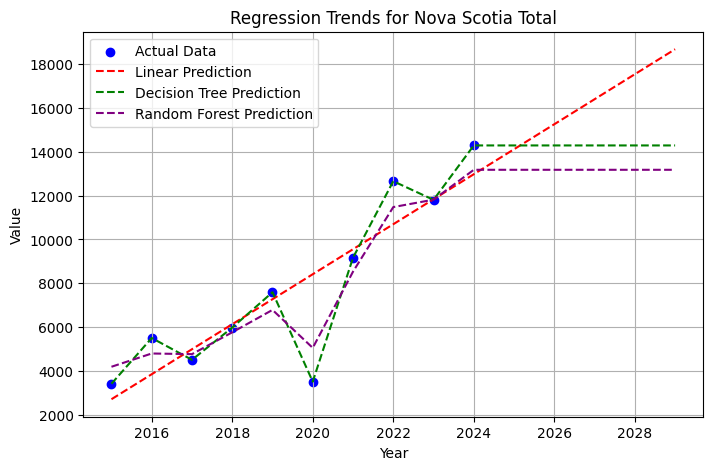

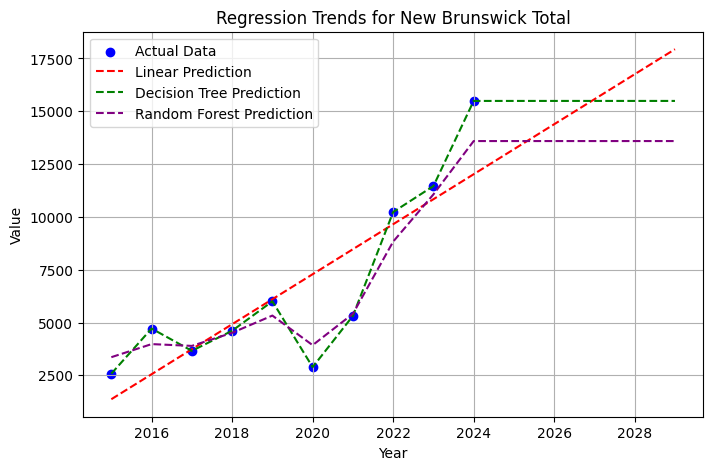

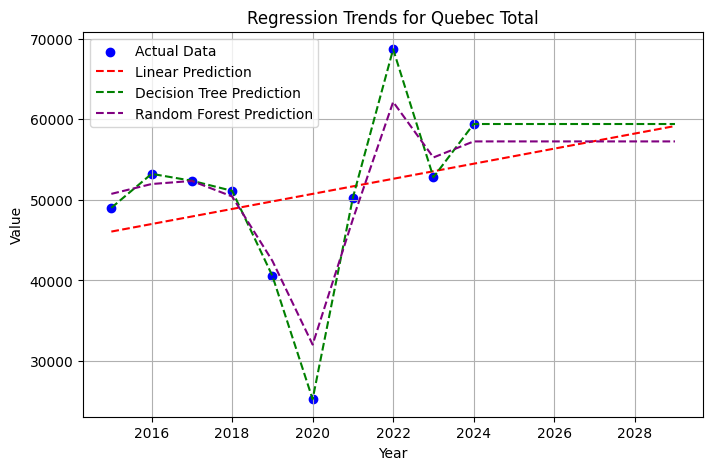

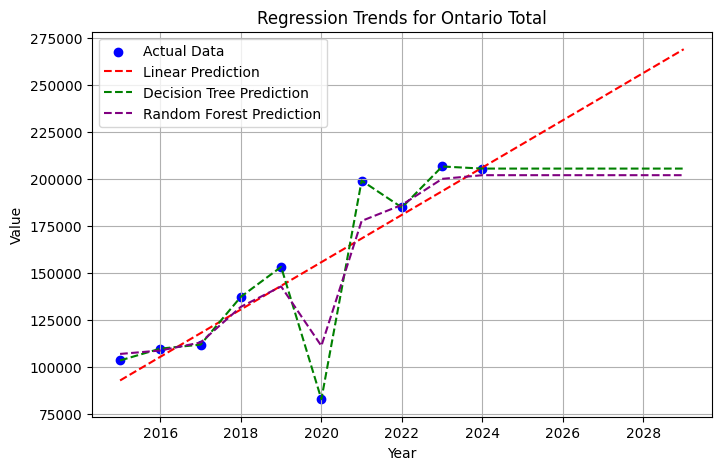

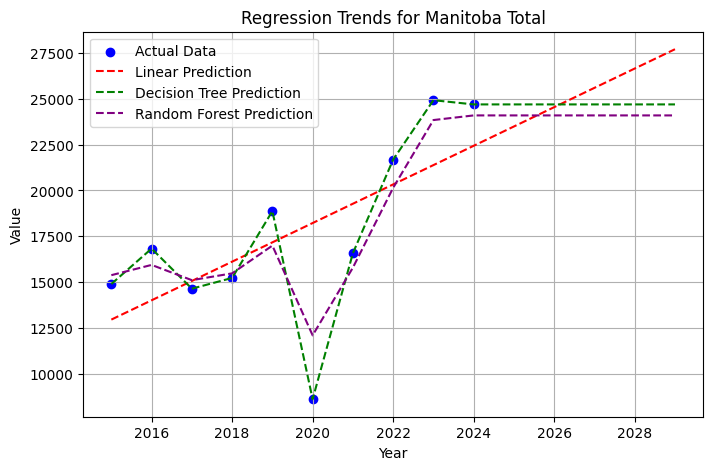

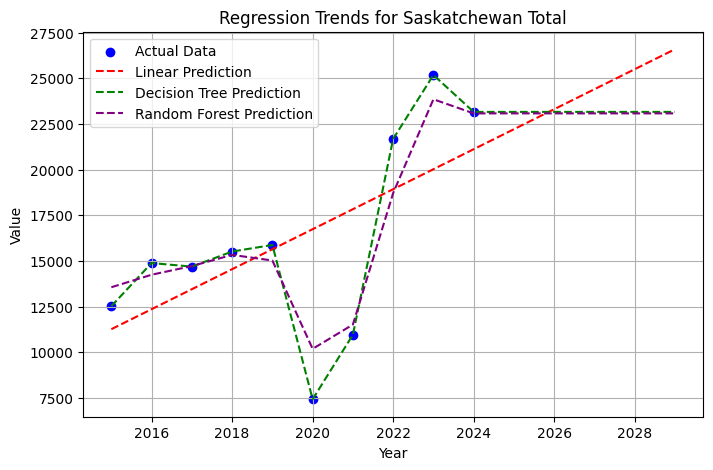

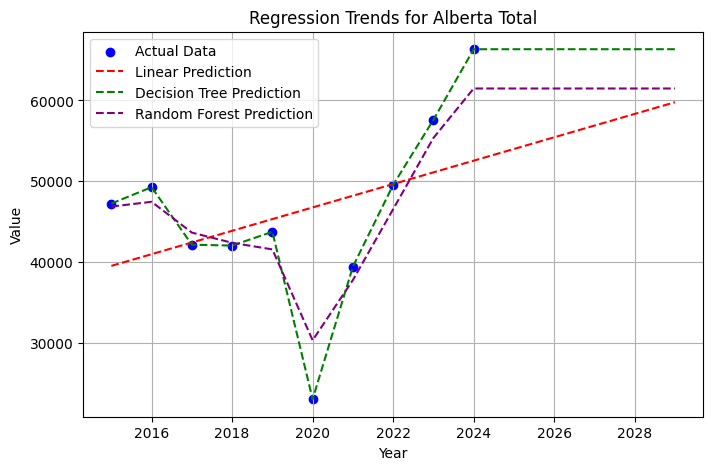

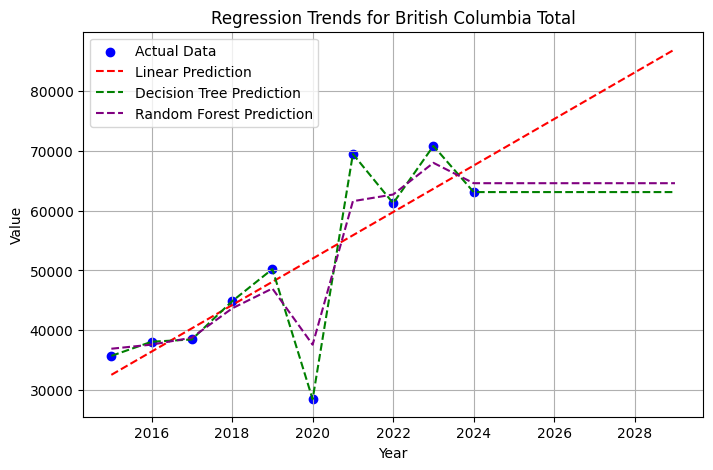

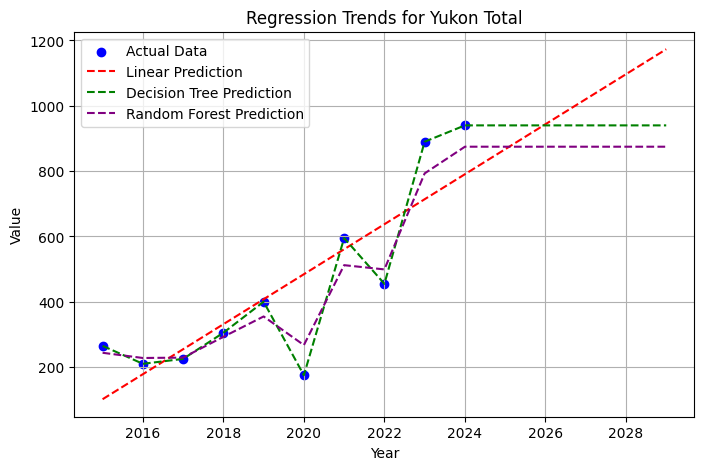

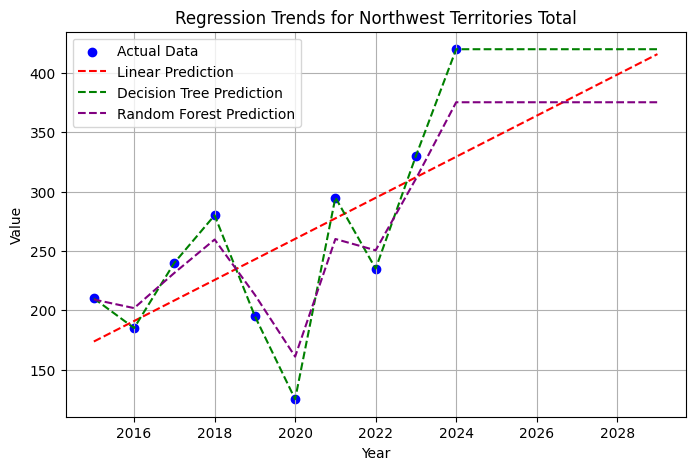

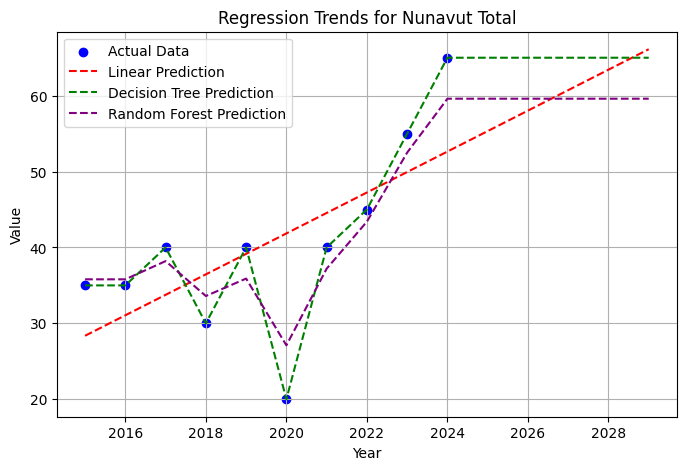

In [31]:
# Required provinces
required_provinces = [
    "Newfoundland and Labrador Total", "Prince Edward Island Total", "Nova Scotia Total",
    "New Brunswick Total", "Quebec Total", "Ontario Total", "Manitoba Total",
    "Saskatchewan Total", "Alberta Total", "British Columbia Total", "Yukon Total",
    "Northwest Territories Total", "Nunavut Total"
]

# Filter for required provinces
df_final_cleaned = df_extracted[df_extracted["Province/Territory"].isin(required_provinces)]

# Prepare data for Linear Regression
years = np.array(list(range(2015, 2025))).reshape(-1, 1)

# Create a plot for each province
for province in df_final_cleaned["Province/Territory"].unique():
    df_province = df_final_cleaned[df_final_cleaned["Province/Territory"] == province]
    values = df_province.iloc[:, 1:].values.flatten()  # Extract numerical values

    # Train linear regression model
    model = LinearRegression()
    model.fit(years, values)
    # Predict future values
    future_years = np.array(list(range(2015, 2030))).reshape(-1, 1)
    lin_predictions = model.predict(future_years)

    # Train Decision Tree Regression model
    tree_model = DecisionTreeRegressor()
    tree_model.fit(years, values)
    tree_predictions = tree_model.predict(future_years)

    # Train Random Forest Regression model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(years, values)
    rf_predictions = rf_model.predict(future_years)

    # Plot actual and predicted data
    plt.figure(figsize=(8, 5))
    plt.scatter(years, values, color='blue', label="Actual Data")
    plt.plot(future_years, lin_predictions, color='red', linestyle="--", label="Linear Prediction")
    plt.plot(future_years, tree_predictions, color='green', linestyle="--", label="Decision Tree Prediction")
    plt.plot(future_years, rf_predictions, color='purple', linestyle="--", label="Random Forest Prediction")
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(f"Regression Trends for {province}")
    plt.legend()
    plt.grid(True)
    plt.show()


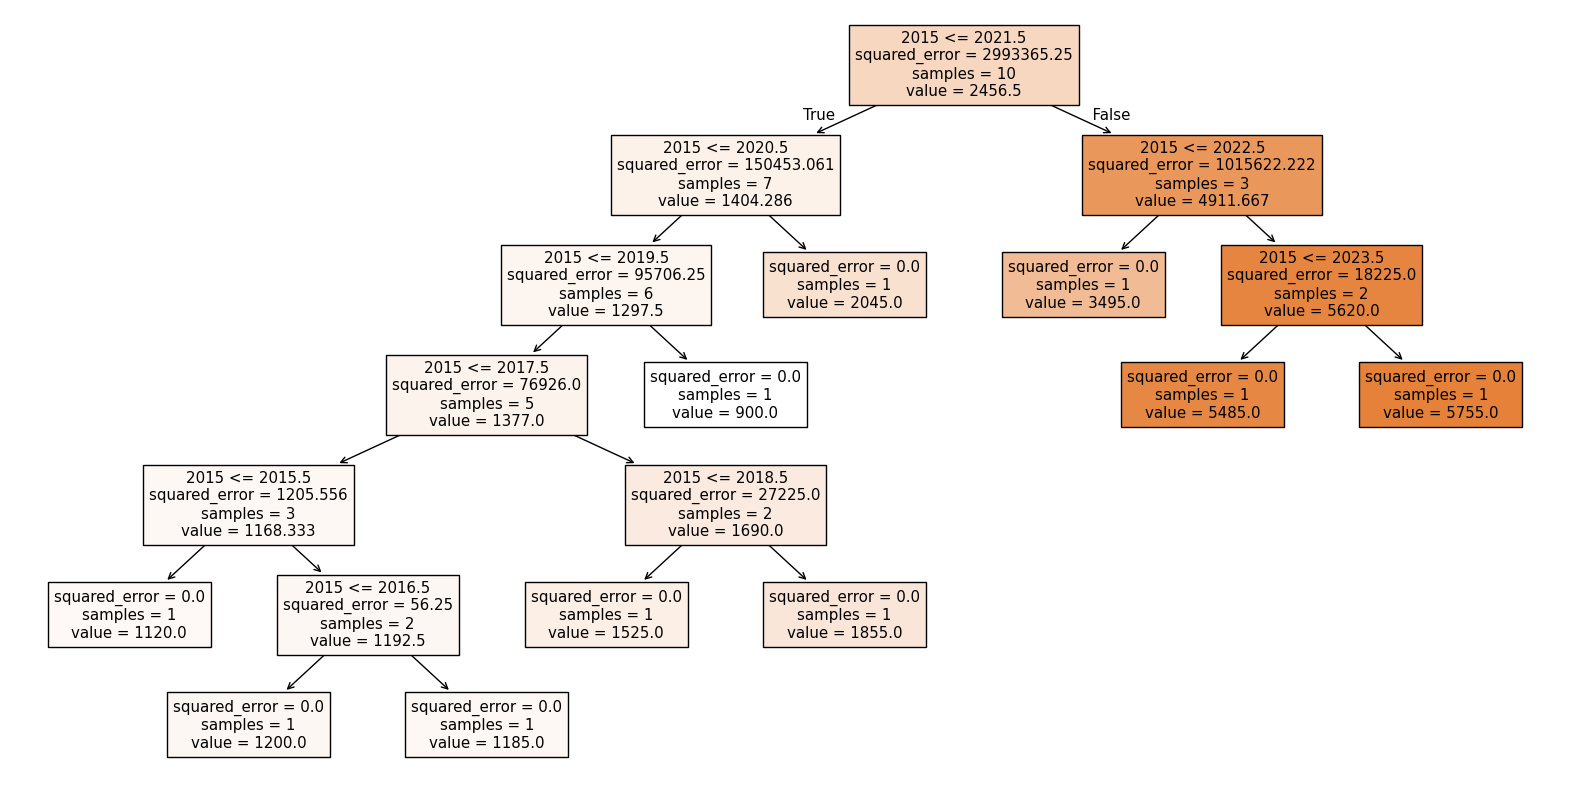

In [ ]:
# Visualize Decision Tree for one province
province = df_final_cleaned["Province/Territory"].unique()[0]  # Selecting the first province
df_province = df_final_cleaned[df_final_cleaned["Province/Territory"] == province]
values = df_province.iloc[:, 1:].values.flatten()  # Extract numerical values

# Train Decision Tree regression model
tree_model = DecisionTreeRegressor()
tree_model.fit(years, values)

# Plot the decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, filled=True, feature_names=[str(year) for year in range(2015, 2025)])
plt.show()


**Steady Growth vs. Fluctuations:** Provinces such as Quebec and Ontario exhibit more stable immigration trends, whereas regions like Newfoundland and Labrador and Prince Edward Island demonstrate significant fluctuations.
COVID-19 Impact (2020): A decline in immigration numbers is observed across most provinces around 2020, likely due to the impact of the COVID-19 pandemic.


**Observed Data Trends**
The immigration data for many provinces shows significant fluctuations over the years rather than a steady linear increase or decrease.
Some provinces, such as Quebec and Ontario, exhibit clear nonlinear trends, which makes linear regression less reliable.
Certain provinces display sharp changes (e.g., Nova Scotia and Alberta), where Decision Tree models captured these variations well but tended to overfit.


**Model Comparisons**

**Linear Regression:**

Works well when data follows a clear trend, but many provinces exhibit non-linear fluctuations, making it less accurate.
Example: Ontario's immigration numbers showed sudden jumps, which a simple linear model couldn't capture.

**Decision Tree Regression:**

It correctly followed sharp increases and decreases, but the step-like structure showed overfitting, meaning it followed noise rather than general trends.
Example: Nova Scotia's trend was overly segmented, and Decision Tree struggled to generalize beyond training data.

**Random Forest Regression:**

Effectively captured long-term trends while smoothing sudden spikes.
It avoided overfitting by averaging multiple decision trees, making predictions more stable and reliable.
Example: British Columbia displayed short-term fluctuations, but Random Forest smoothed predictions while still following the key pattern.

In [ ]:
# Load the Excel file
file_path = files["CitzImmCat"]
xls = pd.ExcelFile(file_path)

In [ ]:
# Load the relevant sheet into a DataFrame
df = pd.read_excel(xls, sheet_name='PR - ImmCat')

In [ ]:
# Removing the first 5045 rows to include Afghanistan
df_trimmed = df.iloc[5045:].reset_index(drop=True)

# Remove the empty columns 'Unnamed: 1' through 'Unnamed: 3'
df_trimmed_cleaned = df_trimmed.drop(columns=['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], errors='ignore')

# Define the new column names
new_column_names = {
    'Unnamed: 4': 'Jan', 'Unnamed: 5': 'Feb', 'Unnamed: 6': 'Mar', 'Unnamed: 7': 'Q1 Total',
    'Unnamed: 8': 'Apr', 'Unnamed: 9': 'May', 'Unnamed: 10': 'Jun', 'Unnamed: 11': 'Q2 Total',
    'Unnamed: 12': 'Jul', 'Unnamed: 13': 'Aug', 'Unnamed: 14': 'Sep', 'Unnamed: 15': 'Q3 Total',
    'Unnamed: 16': 'Oct', 'Unnamed: 17': 'Nov', 'Unnamed: 18': 'Dec', 'Unnamed: 19': 'Q4 Total',
    'Unnamed: 20': '2015 Total'
}

# Extend column name mappings for later years
for year, start_col in zip(range(2016, 2025), range(21, 174, 17)):
    new_column_names.update({
        f'Unnamed: {start_col + i}': col_name for i, col_name in enumerate([
            'Jan', 'Feb', 'Mar', 'Q1 Total', 'Apr', 'May', 'Jun', 'Q2 Total',
            'Jul', 'Aug', 'Sep', 'Q3 Total', 'Oct', 'Nov', 'Dec', 'Q4 Total', f'{year} Total'
        ])
    })

# Rename the columns
df_trimmed_cleaned.rename(columns=new_column_names, inplace=True)


In [ ]:
# Remove rows from index 219 to 222 (since 223 does not exist)
df_trimmed_cleaned = df_trimmed_cleaned.drop(index=range(219, 223)).reset_index(drop=True)

In [ ]:
# Replace all occurrences of '--' with 0
df_trimmed_cleaned.replace('--', 0, inplace=True)

In [ ]:
# Remove all commas from the dataset
df_trimmed_cleaned = df_trimmed_cleaned.replace({',': ''}, regex=True)

In [ ]:
# Convert all data (except the first column with country names) to numeric
df_trimmed_cleaned.iloc[:, 1:] = df_trimmed_cleaned.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

In [ ]:
# Define the columns to retain (yearly totals only)
columns_to_keep = ['Canada - Admissions of Permanent Residents by Country of Citizenship and Immigration Category, January 2015 - December 2024'] + \
                  [f'{year} Total' for year in range(2015, 2025)]

# Retain only the necessary columns
df_trimmed_cleaned = df_trimmed_cleaned[columns_to_keep]


In [ ]:
# Set the index as country names for visualization
df_trimmed_cleaned.set_index(df_trimmed_cleaned.columns[0], inplace=True)

In [ ]:
# Get the top 10 countries with the highest immigration in 2024
top_countries = df_trimmed_cleaned.sort_values(by='2024 Total', ascending=False).head(10)

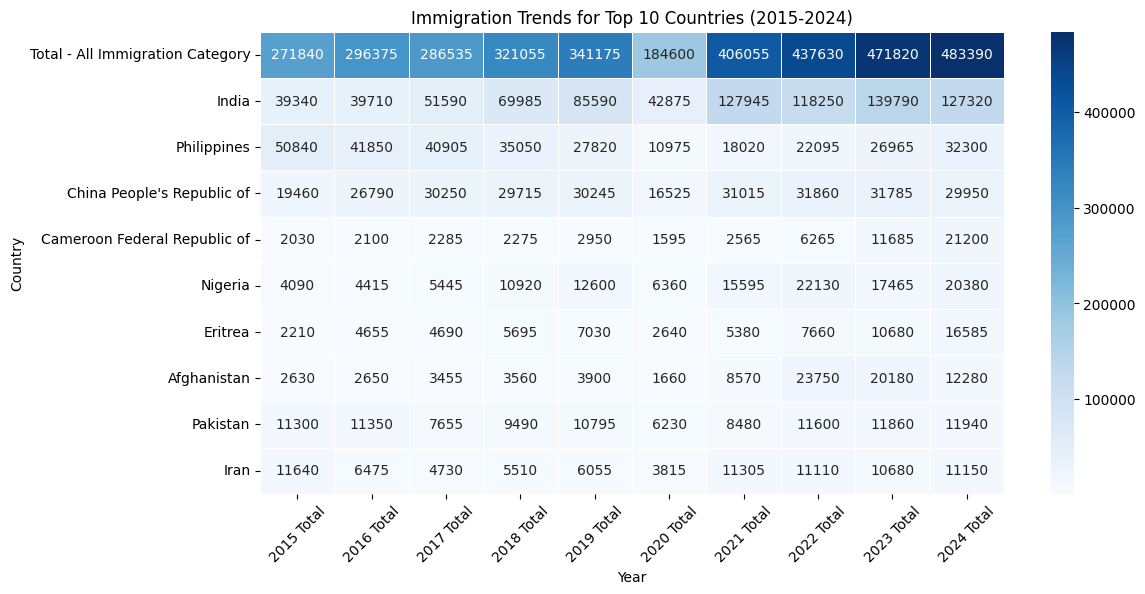

In [ ]:
# Heatmap of immigration trends
plt.figure(figsize=(12, 6))
sns.heatmap(top_countries.astype(float), annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)
plt.title("Immigration Trends for Top 10 Countries (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.xticks(rotation=45)
plt.show()

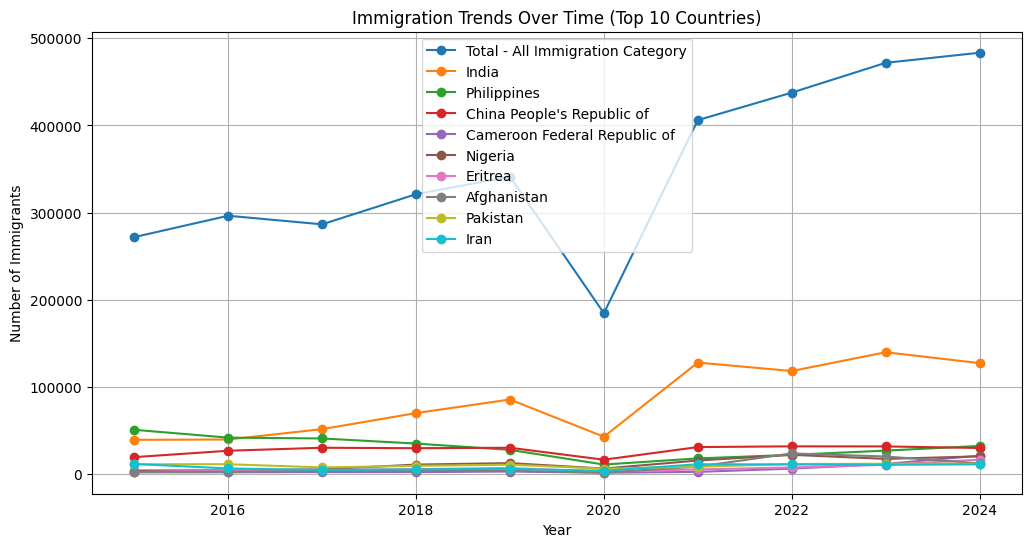

In [ ]:
# Line chart of immigration trends over time
plt.figure(figsize=(12, 6))
for country in top_countries.index:
    plt.plot(range(2015, 2025), top_countries.loc[country], marker='o', label=country)

plt.title("Immigration Trends Over Time (Top 10 Countries)")
plt.xlabel("Year")
plt.ylabel("Number of Immigrants")
plt.legend()
plt.grid(True)
plt.show()

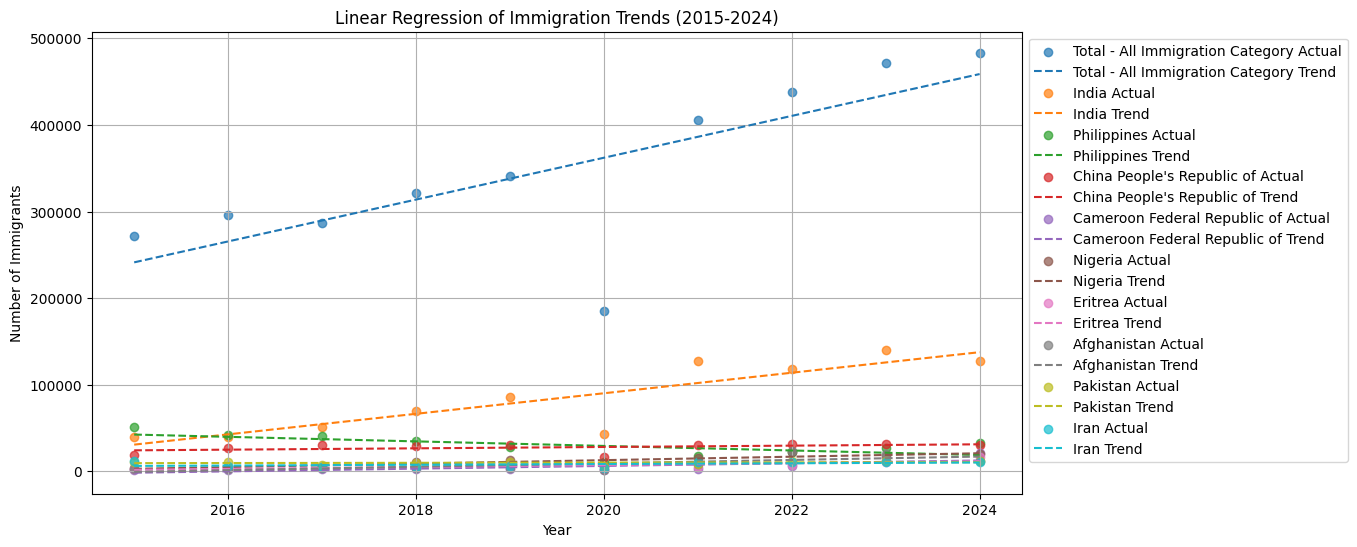

In [ ]:
# Simple Linear Regression Analysis
years = np.array(range(2015, 2025)).reshape(-1, 1)  # Years as independent variable

# Initialize plot
plt.figure(figsize=(12, 6))

# Perform linear regression for each country and plot
for country in top_countries.index:
    y_values = top_countries.loc[country].values.reshape(-1, 1)  # Immigration numbers as dependent variable
    model = LinearRegression()
    model.fit(years, y_values)  # Fit model
    predictions = model.predict(years)  # Predict values

    # Plot actual and predicted values
    plt.scatter(years, y_values, label=f'{country} Actual', alpha=0.7)
    plt.plot(years, predictions, linestyle='dashed', label=f'{country} Trend')

# Customize plot
plt.title("Linear Regression of Immigration Trends (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Number of Immigrants")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

**Overall Growth Trends**

The majority of the top 10 countries exhibit positive slopes in their linear regression trends, indicating an overall increase in immigration to Canada over the past decade.
Some countries have steeper slopes than others, suggesting a rapid increase in immigration rates, while others show a more stable or slower increase.


**Top Growth Countries**

The countries with the highest regression slopes (steepest increase) suggest that their immigration rates have significantly increased since 2015.
If trends continue, these countries might remain top sources of immigration for Canada in the coming years.


**Potential Stabilization or Decline**

Some countries show flat or slightly declining trends in immigration numbers.
If a country’s trendline is relatively horizontal, it means immigration has remained stable over the years.
If there’s a slight downward trend, this might indicate a decreasing interest or stricter immigration policies affecting applicants from those countries.

**Prediction for Future Immigration**

Given the regression trends, if current patterns persist, Canada can expect continued growth in immigration from the top-performing countries.
However, external factors such as economic conditions, policy changes, or geopolitical issues can disrupt these linear trends.

**Variability in Growth Patterns**

Some countries show year-over-year fluctuations rather than a steady increase or decrease.
The linear regression provides a generalized trend, but deviations in actual immigration numbers suggest that factors like policy changes, global crises, or specific immigration programs might influence annual variations.

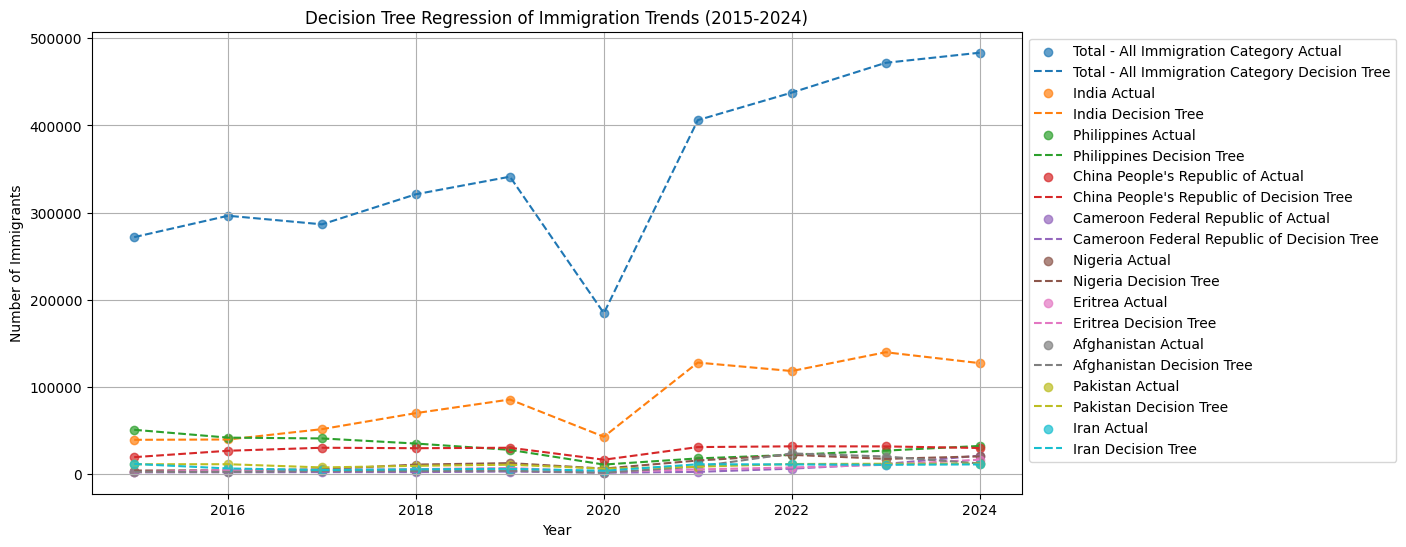

In [ ]:
# Decision Tree Regression
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model for each country in the top 10
plt.figure(figsize=(12, 6))
for country in top_countries.index:
    y_values = top_countries.loc[country].values.reshape(-1, 1)  # Immigration numbers as dependent variable
    dt_model.fit(years, y_values)  # Fit model
    predictions = dt_model.predict(years)  # Predict values

    # Plot actual and predicted values
    plt.scatter(years, y_values, label=f'{country} Actual', alpha=0.7)
    plt.plot(years, predictions, linestyle='dashed', label=f'{country} Decision Tree')

# Customize plot
plt.title("Decision Tree Regression of Immigration Trends (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Number of Immigrants")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

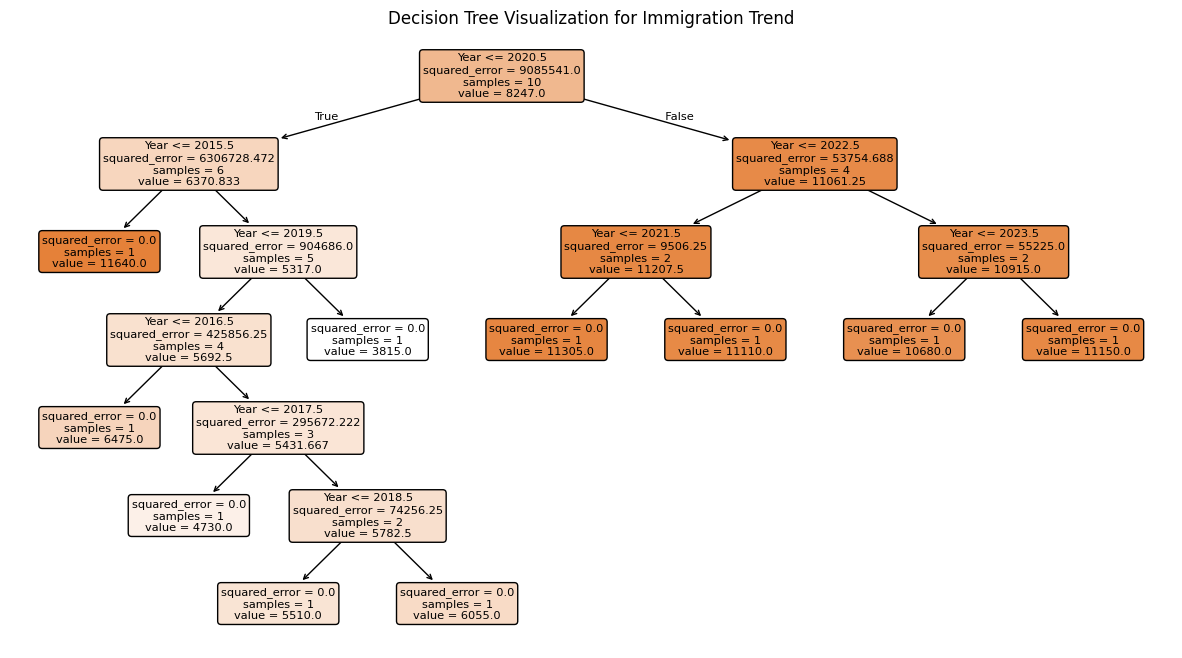

In [ ]:
# Visualizing one of the decision trees
plt.figure(figsize=(15, 8))
tree.plot_tree(dt_model, feature_names=['Year'], filled=True, rounded=True)
plt.title("Decision Tree Visualization for Immigration Trend")
plt.show()

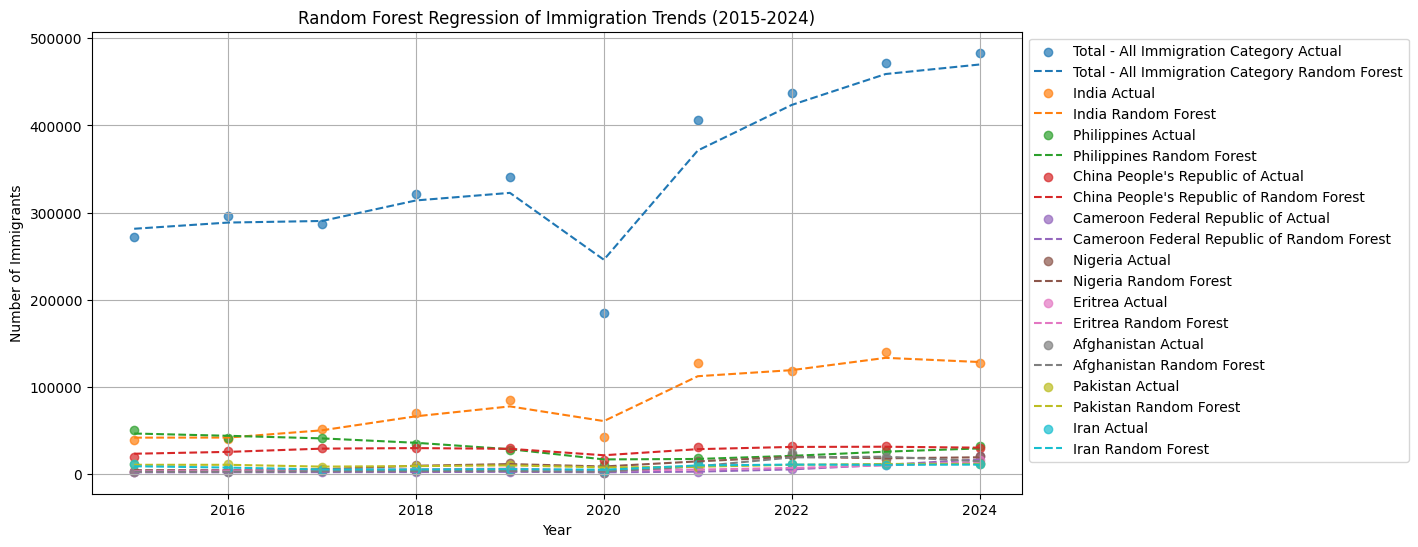

In [ ]:
# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model for each country in the top 10
plt.figure(figsize=(12, 6))
for country in top_countries.index:
    y_values = top_countries.loc[country].values.reshape(-1, 1)  # Immigration numbers as dependent variable
    rf_model.fit(years, y_values.ravel())  # Fit model
    predictions = rf_model.predict(years)  # Predict values

    # Plot actual and predicted values
    plt.scatter(years, y_values, label=f'{country} Actual', alpha=0.7)
    plt.plot(years, predictions, linestyle='dashed', label=f'{country} Random Forest')

# Customize plot
plt.title("Random Forest Regression of Immigration Trends (2015-2024)")
plt.xlabel("Year")
plt.ylabel("Number of Immigrants")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

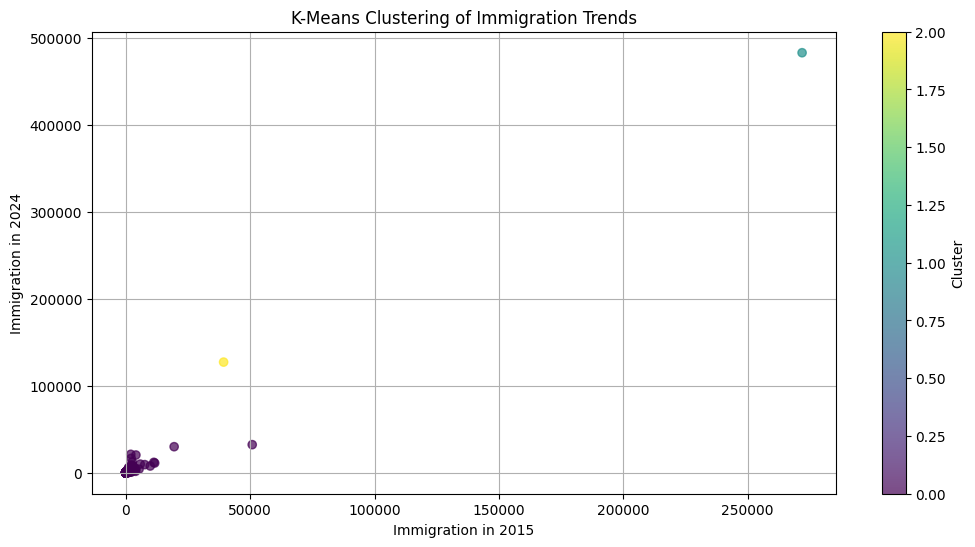

,2015 Total,2016 Total,2017 Total,2018 Total,2019 Total,2020 Total,2021 Total,2022 Total,2023 Total,2024 Total
"Canada - Admissions of Permanent Residents by Country of Citizenship and Immigration Category, January 2015 - December 2024",,,,,,,,,,
Afghanistan,2630.0,2650.0,3455.0,3560.0,3900.0,1660.0,8570.0,23750.0,20180.0,12280.0
Albania,565.0,510.0,645.0,650.0,625.0,285.0,550.0,520.0,655.0,610.0
Algeria,2830.0,2820.0,2635.0,3225.0,3705.0,2720.0,3080.0,6175.0,5245.0,8255.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,30.0,30.0,45.0,35.0,65.0,35.0,150.0,240.0,235.0,205.0
...,...,...,...,...,...,...,...,...,...,...
Zambia,55.0,55.0,85.0,70.0,75.0,50.0,95.0,85.0,90.0,100.0
Zimbabwe,230.0,280.0,420.0,595.0,565.0,345.0,510.0,605.0,555.0,595.0
Country not stated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean') # Impute missing values with the mean

# Impute NaNs before scaling
data_to_scale = df_trimmed_cleaned.iloc[:, :-1]
imputed_data = imputer.fit_transform(data_to_scale)

scaled_data = scaler.fit_transform(imputed_data)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

# K-Means Visualization
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_trimmed_cleaned['2015 Total'], df_trimmed_cleaned['2024 Total'],
                      c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("Immigration in 2015")
plt.ylabel("Immigration in 2024")
plt.title("K-Means Clustering of Immigration Trends")
plt.grid(True)
plt.show()

# Display clustered data
display(df_trimmed_cleaned)

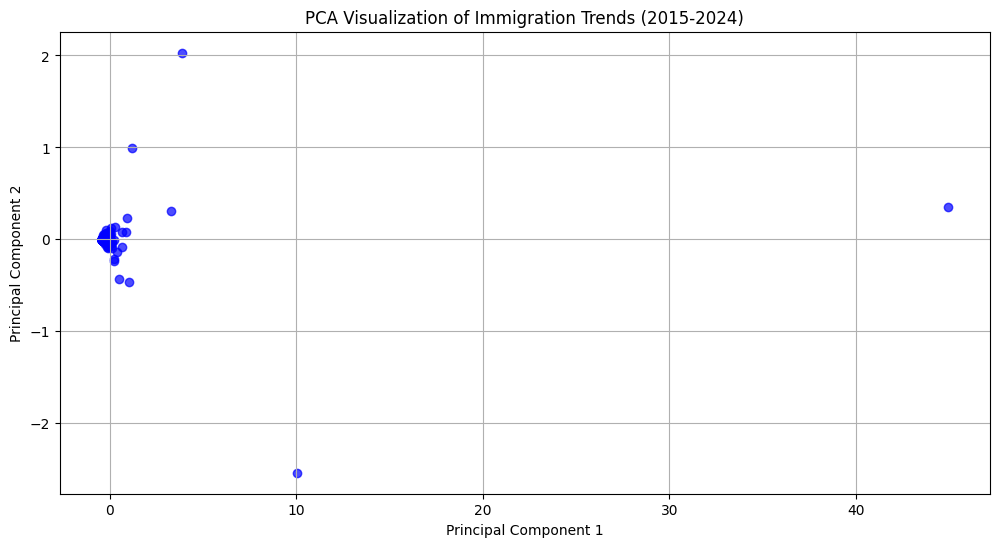

Explained Variance Ratio: [0.99309186 0.00570826]


In [ ]:
# PCA - Principal Component Analysis
scaler = StandardScaler()

# Imputing missing values before scaling
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean
data_to_scale = df_trimmed_cleaned.values # Get the numerical data
imputed_data = imputer.fit_transform(data_to_scale)

scaled_data = scaler.fit_transform(imputed_data)

# Applying PCA to reduce dimensions
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_trimmed_cleaned.index) # using the original index

# Visualizing the PCA results
plt.figure(figsize=(12, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7, color='blue')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Immigration Trends (2015-2024)")
plt.grid(True)
plt.show()

# Display explained variance ratio
pca_explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", pca_explained_variance)

In [ ]:

# Initialize dictionaries to store model performance
model_performance = {
    'Linear Regression': {'MAE': [], 'MSE': [], 'R2': []},
    'Decision Tree': {'MAE': [], 'MSE': [], 'R2': []},
    'Random Forest': {'MAE': [], 'MSE': [], 'R2': []}
}

# Evaluate each model for each country
for country in top_countries.index:
    y_values = top_countries.loc[country].values.reshape(-1, 1)
    years = np.array(range(2015, 2025)).reshape(-1, 1)

    # Linear Regression
    lin_model = LinearRegression()
    lin_model.fit(years, y_values)
    lin_preds = lin_model.predict(years)
    model_performance['Linear Regression']['MAE'].append(mean_absolute_error(y_values, lin_preds))
    model_performance['Linear Regression']['MSE'].append(mean_squared_error(y_values, lin_preds))
    model_performance['Linear Regression']['R2'].append(r2_score(y_values, lin_preds))

    # Decision Tree
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(years, y_values)
    dt_preds = dt_model.predict(years)
    model_performance['Decision Tree']['MAE'].append(mean_absolute_error(y_values, dt_preds))
    model_performance['Decision Tree']['MSE'].append(mean_squared_error(y_values, dt_preds))
    model_performance['Decision Tree']['R2'].append(r2_score(y_values, dt_preds))

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(years, y_values.ravel())
    rf_preds = rf_model.predict(years)
    model_performance['Random Forest']['MAE'].append(mean_absolute_error(y_values, rf_preds))
    model_performance['Random Forest']['MSE'].append(mean_squared_error(y_values, rf_preds))
    model_performance['Random Forest']['R2'].append(r2_score(y_values, rf_preds))

# Compute the average performance across all countries
performance_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MAE': [
        sum(model_performance['Linear Regression']['MAE']) / len(top_countries),
        sum(model_performance['Decision Tree']['MAE']) / len(top_countries),
        sum(model_performance['Random Forest']['MAE']) / len(top_countries)
    ],
    'MSE': [
        sum(model_performance['Linear Regression']['MSE']) / len(top_countries),
        sum(model_performance['Decision Tree']['MSE']) / len(top_countries),
        sum(model_performance['Random Forest']['MSE']) / len(top_countries)
    ],
    'R2': [
        sum(model_performance['Linear Regression']['R2']) / len(top_countries),
        sum(model_performance['Decision Tree']['R2']) / len(top_countries),
        sum(model_performance['Random Forest']['R2']) / len(top_countries)
    ]
})

# Display model performance comparison
display(performance_df)


# Determine the best model based on R² score
best_model = performance_df.loc[performance_df['R2'].idxmax(), 'Model']
print(f"Based on the R² score, the best performing model is: {best_model}")

,Model,MAE,MSE,R2
0,Linear Regression,7416.296364,4.158931e+08,0.471246
1,Decision Tree,0.000000,0.000000e+00,1.000000
2,Random Forest,3294.269000,7.000565e+07,0.911815


Based on the R² score, the best performing model is: Decision Tree
